#### Run Options: Set these options before running

In [1]:
fn_h5 = 'tf_mnist_model_az_09.h5'
fn_tflite = 'tf_mnist_model_az_09.tflite'
class_labels = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

save_as_tflite = True
train = True
n_epochs = 10

#### 0. Import Modules

In [2]:
from ImageUtilities import *
from MNISTUtilities import *
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

#### 1. Read MNIST

Reading: emnist-byclass-mapping.txt  ...
Reading: emnist-byclass-test-images-idx3-ubyte.gz  ...
2051 116323 28 28
(116323, 28, 28)
Reading: emnist-byclass-test-labels-idx1-ubyte.gz  ...
2049 116323 0 0
(116323,)
Reading: emnist-byclass-train-images-idx3-ubyte.gz  ...
2051 697932 28 28
(697932, 28, 28)
Reading: emnist-byclass-train-labels-idx1-ubyte.gz  ...
2049 697932 0 0
(697932,)
(697932, 784)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
62
Train Set:


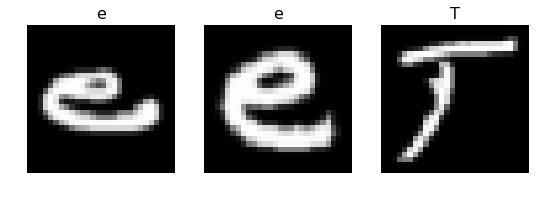

Test Set:


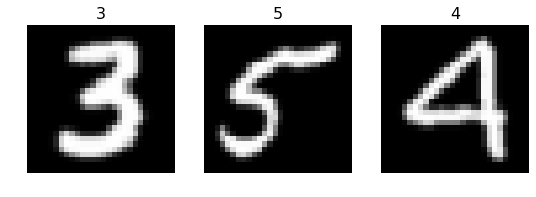

In [3]:
X_train, X_test, y_train, y_test = read_and_transform_MNIST_data(dir_path='../../../data/mnist_az/gzip/', category='by-class')

print(np.unique(y_train))
print(len(class_labels))
#Sanity Check
sanity_check(X_train, X_test, y_train, y_test, class_labels)

#### 2. Model Training

##### 2.1 Build and Compile Model

In [4]:
if(train == True):
    rows = X_train.shape[0]
    dims = X_train.shape[1]
    classes = np.unique(y_test).shape[0]
    print(rows, dims, classes)

    model = tf.keras.models.Sequential([
        keras.layers.Dense(200, activation=tf.keras.activations.relu, input_shape=(dims,)),
        keras.layers.Dense(100, activation=tf.keras.activations.relu),
        keras.layers.Dense(50, activation=tf.keras.activations.relu),
        keras.layers.Dense(classes, activation=tf.keras.activations.softmax)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.sparse_categorical_crossentropy ,
                     metrics=['accuracy'])

    model.summary()

697932 784 62
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 62)                3162      
Total params: 185,312
Trainable params: 185,312
Non-trainable params: 0
_________________________________________________________________


##### 2.2 Train Model

In [5]:
if(train == True):
    model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
697932/697932 [==============================] - 93s 134us/sample - loss: 0.6401 - acc: 0.7923
Epoch 2/10
697932/697932 [==============================] - 90s 130us/sample - loss: 0.4999 - acc: 0.8273
Epoch 3/10
697932/697932 [==============================] - 90s 130us/sample - loss: 0.4738 - acc: 0.8349
Epoch 4/10
697932/697932 [==============================] - 91s 130us/sample - loss: 0.4591 - acc: 0.8389
Epoch 5/10
697932/697932 [==============================] - 90s 129us/sample - loss: 0.4499 - acc: 0.8415
Epoch 6/10
697932/697932 [==============================] - 91s 130us/sample - loss: 0.4438 - acc: 0.8437
Epoch 7/10
697932/697932 [==============================] - 91s 130us/sample - loss: 0.4398 - acc: 0.8452
Epoch 8/10
697932/697932 [==============================] - 91s 130us/sample - loss: 0.4357 - acc: 0.8461
Epoch 9/10
697932/697932 [==============================] - 91s 130us/sample - loss: 0.4331 - acc: 0.8470
Epoch 10/10
697932/697932 [===================

##### 2.3 Evaluate Trained Model

In [6]:
if(train == True):
    loss, acc = model.evaluate(X_test, y_test)
    print("Evaluation: [loss: {}, acc: {}]".format(loss, acc))

116323/116323 [==============================] - 6s 50us/sample - loss: 0.4744 - acc: 0.8401
Evaluation: [loss: 0.47436042503960407, acc: 0.8400574326515198]


#### 3. Save Trained Model (as .h5 file)  & Optionally covert to .tflite for deployment

In [7]:
if(train == True):
    #Save trained model
    model.save(fn_h5)

#Convert model to tflite format
if (save_as_tflite == True):
    converter = tf.lite.TFLiteConverter.from_keras_model_file(fn_h5)
    mnist_digits_model = converter.convert()
    open(fn_tflite, "wb").write(mnist_digits_model)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


#### 4. User Image Processing and Prediction

###### i. Read Image

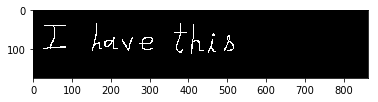

In [14]:
img = cv2.imread('../a03.png')
img_bin = binary_image(img)

plt.imshow(img_bin, cmap='gray')
plt.show()

###### ii. Extract Characters and Preprocess Each Sub-Image

In [15]:
def preprocess(img_seg, flatten=True, scale_features=True, display_steps=False):
    rows, cols = img_seg.shape
    
    #(1) Fit to 20x20 box preserving aspect ratio
    max_dim = 20
    img_fitted = fitImage(img_seg, max_dim)
    rows, cols = img_fitted.shape
    
    if(display_steps == True):
        plt.title("{}, {}".format(i, img_fitted.shape))
        plt.imshow(img_fitted, cmap='gray')
        plt.show()
    
    #(2) Pad to 28x28 image
    reqr, reqc = 28, 28
    img_padded = padImage(img_fitted, reqr, reqc)

    if(display_steps == True):
        plt.title(i)
        plt.imshow(img_padded, cmap='gray')
        plt.show()
    
    #(3) Transform / Center image
    shX, shY = getTransform(img_padded)
    img_transformed = transformImage(img_padded ,shX, shY)
    
    if(display_steps == True):
        plt.title(i)
        plt.imshow(img_transformed, cmap='gray')
        plt.show()
        
    #(4) Flatten image
    if(flatten == True):
        img_transformed = np.reshape(img_transformed, (1, -1))
        
    #(5) Scale features
    if(scale_features == True):
        img_transformed = img_transformed / 255.0
       
    return img_transformed

174 863
174 863
9


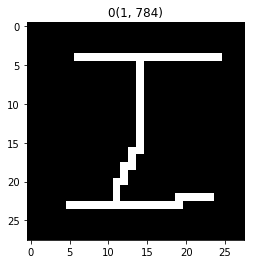

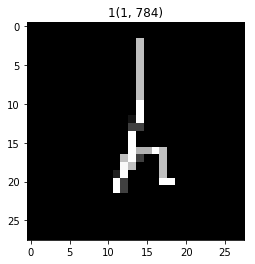

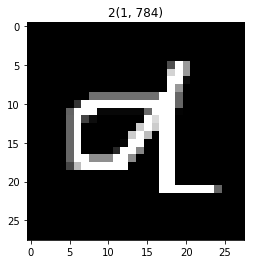

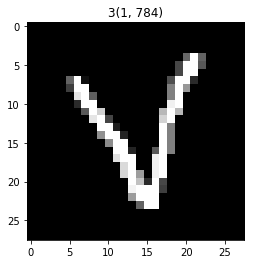

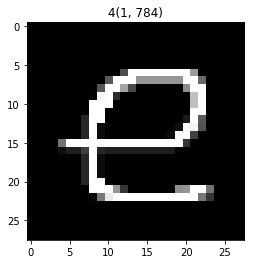

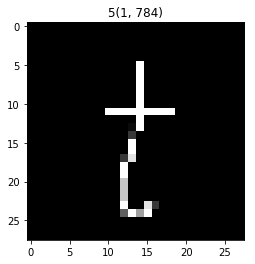

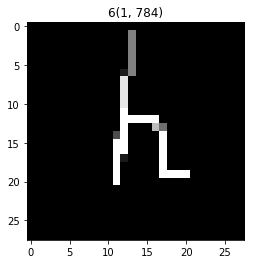

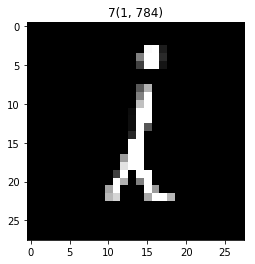

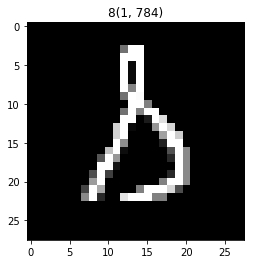

In [16]:
seg_list = segment_image(img_bin)
print(len(seg_list))

for i in range(len(seg_list)):
    seg_list[i] = preprocess(seg_list[i])
    
    plt.title(str(i) + str(seg_list[i].shape ))
    plt.imshow(seg_list[i].reshape((28, 28)), cmap='gray')
    plt.show() 

###### iii. Load Pre-trained Model and Make Predictions

In [17]:
#(1) Load Pretrained Model
interpreter = tf.contrib.lite.Interpreter(model_path="tf_mnist_model_az.tflite")
interpreter.allocate_tensors()

#(2) Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

ip_idx, ip_shape = input_details[0]['index'], input_details[0]['shape']
op_idx, op_shape = output_details[0]['index'], output_details[0]['shape']
print("Tensorflow Model Expects:")
print("Input:\n\tIndex: {}\n\tShape: {}".format(ip_idx, ip_shape))
print("Output:\n\tIndex: {}\n\tShape: {}".format(op_idx, op_shape))

input_data = seg_list[0].astype(np.float32)
print("Provided Input Shape: ", input_data.shape)

#(3) Test model on user input data.
predictions = ["" for i in range(len(seg_list))]
for i in range(len(seg_list)):
    input_data = seg_list[i].astype(np.float32)
    interpreter.set_tensor(ip_idx, input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(op_idx)
    
    predictions[i] = class_labels[np.argmax(output_data)]

Tensorflow Model Expects:
Input:
	Index: 13
	Shape: [  1 784]
Output:
	Index: 11
	Shape: [ 1 26]
Provided Input Shape:  (1, 784)


###### iv. Display Predictions 

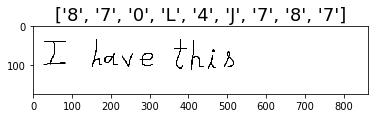

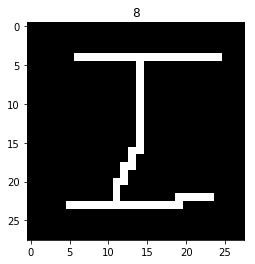

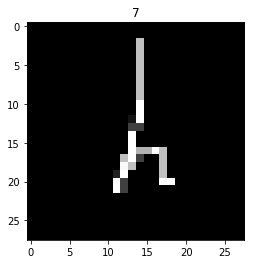

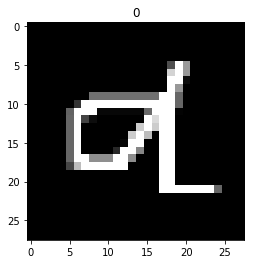

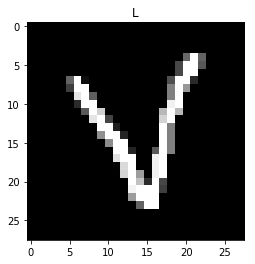

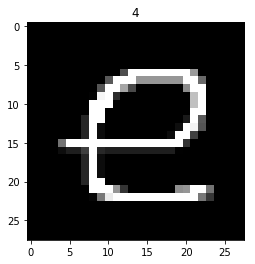

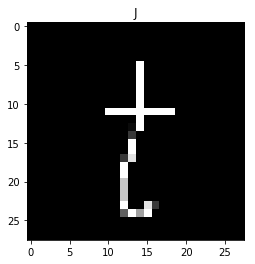

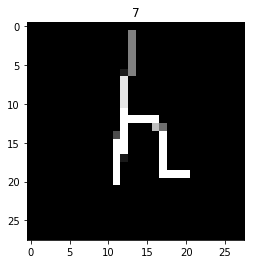

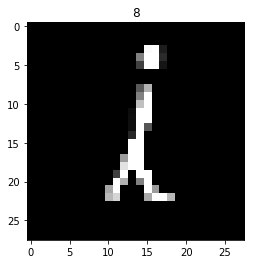

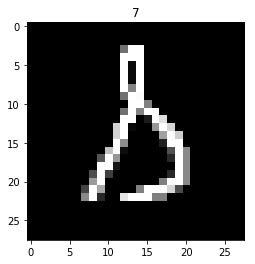

In [18]:
plt.title(predictions, fontsize=18)
plt.imshow(img, cmap='gray')
plt.show()

for i in range(len(seg_list)):
    plt.title(predictions[i])
    plt.imshow(seg_list[i].reshape((28, 28)), cmap='gray')
    plt.show() 
    

#### 5. Summary

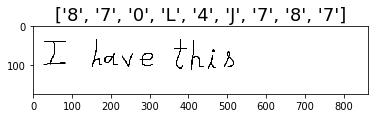

Test Set:
	Accuracy: 0.8400574326515198%
	Loss: 0.47436042503960407


Model Configuration:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 62)                3162      
Total params: 185,312
Trainable params: 185,312
Non-trainable params: 0
_________________________________________________________________


In [19]:
plt.title(predictions, fontsize=18)
plt.imshow(img, cmap='gray')
plt.show()

print("Test Set:\n\tAccuracy: {}%\n\tLoss: {}\n\n".format(acc, loss))
print('Model Configuration:')
model.summary()